Remaining to-dos:

- Update dataset representations
    - Word-level semantic ID
- don't apply loss on padded elements
- wav2vec2 distillation control

In [1]:
from pathlib import Path

import datasets
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import torch
import transformers
from transformers import AutoConfig
from transformers import Wav2Vec2Model
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from models.transformer import Wav2Vec2ForSpeechClassification, DataCollator, \
    drop_wav2vec_layers
from utils.timit import TimitCorpus

In [4]:
datasets.disable_caching()

In [5]:
model_name_or_path = "facebook/wav2vec2-base-960h"

processor = transformers.Wav2Vec2Processor.from_pretrained(model_name_or_path)

In [30]:
output_dir = "testrun8"
drop_phones = ["pau", "epi", "h#"]

In [7]:
def get_phone_vocab(corpus):
    from models import Vocabulary
    phone_vocab = Vocabulary("phones")
    corpus.map(lambda x: [phone_vocab.add_token(phon) for phon in x["phonetic_detail"]["utterance"]] and None,
               batched=False, load_from_cache_file=False)
    return phone_vocab

def prepare_corpus():
    corpus = datasets.load_dataset("timit_asr", data_dir="/userdata/jgauthier/data/TIMIT")

    from utils.timit import group_phonetic_detail
    corpus = corpus.map(group_phonetic_detail, batched=False, load_from_cache_file=False, drop_phones=drop_phones)

    phone_vocab = get_phone_vocab(corpus)
    
    def prepare_audio(batch):
        audio = batch["audio"]
        batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
        return batch
    corpus = corpus.map(prepare_audio)

    from models.transformer import TilingWordFeatureExtractor2
    twfe = TilingWordFeatureExtractor2(phone_vocab.index2token)
    def add_features(example):
        example["phone_targets"] = twfe(example)
        return example
    corpus = corpus.map(add_features, load_from_cache_file=False)
    
    return corpus, phone_vocab

In [8]:
corpus_path = "timit_corpus"

if not Path(corpus_path).exists():
    corpus, phone_vocab = prepare_corpus()
    corpus.save_to_disk(corpus_path)
else:
    corpus = datasets.load_from_disk(corpus_path)
    phone_vocab = get_phone_vocab(corpus)

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [9]:
# Load wav2vec2
config = AutoConfig.from_pretrained(
    model_name_or_path,
    problem_type="multi_label_classification",
    num_labels=len(phone_vocab))
setattr(config, "pooling_mode", "mean")
setattr(config, "classifier_bias", False)

In [10]:
device = "cuda"

In [11]:
def model_init(trial):
    model = Wav2Vec2ForSpeechClassification.from_pretrained(
        model_name_or_path, config=config).to(device)

    model.freeze_feature_extractor()
    model.wav2vec2 = drop_wav2vec_layers(model.wav2vec2, 10)
    
    return model

## Train

In [12]:
def compute_metrics(p: transformers.EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = preds.reshape((-1, preds.shape[-1]))
    labels = p.label_ids.reshape((-1, preds.shape[-1]))

    def evaluate_label(j):
        preds_j = preds[:, j]
        labels_j = labels[:, j]

        mask = labels_j != -100
        preds_j = preds_j[mask]
        labels_j = labels_j[mask]
        if labels_j.std() == 0:
            # Only one class. Quit
            return None
        return roc_auc_score(labels_j, preds_j)

    roc_auc_scores = [evaluate_label(j) for j in range(preds.shape[-1])]
    return {"roc_auc": np.mean([score for score in roc_auc_scores if score is not None])}

    # preds = np.argmax(preds, axis=-1)
    # return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [57]:
coll = DataCollator(processor=processor, model=model_init(None), padding=True,
                    num_labels=len(phone_vocab.index2token))

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.out_proj.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
training_args = TrainingArguments(
    output_dir=output_dir,
    group_by_length=True,
    per_device_train_batch_size=16,
    evaluation_strategy="steps",
    num_train_epochs=2,
    gradient_accumulation_steps=2,
    save_steps=25,
    eval_steps=25,
    logging_steps=2,
    learning_rate=1e-4,
    save_total_limit=5,
    use_cpu=False,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    # disable_tqdm=True,
)

trainer = Trainer(
    model=None, model_init=model_init,
    data_collator=coll,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    compute_metrics=compute_metrics,
    train_dataset=corpus["train"],
    eval_dataset=corpus["test"],
    tokenizer=processor.feature_extractor,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initi

In [15]:
# from ray import tune
# def hp_space(trial):
#     return {
#         "learning_rate": tune.loguniform(1e-5, 1e-3),
#     }

# reporter = tune.CLIReporter(
#     parameter_columns={
#         "learning_rate": "lr",
#     },
#     metric_columns=["eval_loss", "eval_roc_auc", "epoch", "training_iteration"],
# )

# best_trial = trainer.hyperparameter_search(
#     direction="minimize",
#     backend="ray",
#     resources_per_trial={"gpu": 1},
#     hp_space=hp_space,
#     n_trials=2,
#     progress_reporter=reporter)

In [59]:
# # Manual
model = model_init(None)
batch = next(iter(trainer.get_train_dataloader()))
model(**batch)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.out_proj.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SpeechClassifierOutput(loss=tensor(0.6940, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), logits=tensor([[[ 1.2901e-01, -8.8855e-02, -4.8092e-02,  ...,  1.9318e-01,
          -2.5636e-01,  1.3407e-01],
         [ 9.1066e-02, -4.9624e-02,  1.5890e-02,  ...,  5.9200e-02,
          -1.4068e-01,  1.3548e-01],
         [ 4.1924e-02,  4.1703e-02, -6.9246e-06,  ..., -6.6878e-02,
          -1.0233e-01,  1.1454e-02],
         ...,
         [ 1.3849e-02,  1.3306e-01,  4.7259e-02,  ..., -2.0943e-01,
          -2.1649e-01, -6.3637e-02],
         [ 5.2949e-02,  1.5927e-01,  1.5206e-01,  ..., -7.5459e-02,
          -3.4290e-01, -2.1376e-02],
         [ 6.0811e-02,  1.9211e-01,  2.4448e-02,  ...,  8.7050e-02,
          -2.3412e-01,  1.7600e-02]],

        [[ 1.9919e-01, -5.2547e-02, -3.3811e-02,  ...,  7.3679e-02,
          -7.8784e-02,  1.3301e-01],
         [ 2.6985e-01,  3.0737e-02,  2.6858e-02,  ...,  5.1125e-02,
          -8.5536e-02,  1.6087e-01],
         [ 2.8318e-0

In [60]:
list(batch.keys())

['input_values', 'attention_mask', 'labels']

In [62]:
model(**batch)

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.28 GiB (GPU 0; 11.78 GiB total capacity; 6.17 GiB already allocated; 2.16 GiB free; 8.44 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [17]:
# trainer.evaluate()

In [18]:
trainer.train()

Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.out_proj.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/userdata/jgauthier/transformers/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Roc Auc
25,0.474300,0.387565,0.533777
50,0.367900,0.303804,0.533060
75,0.321800,0.271563,0.535986


/userdata/jgauthier/transformers/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/userdata/jgauthier/transformers/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/userdata/jgauthier/transformers/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=96, training_loss=0.4165477715432644, metrics={'train_runtime': 334.1984, 'train_samples_per_second': 27.648, 'train_steps_per_second': 0.287, 'total_flos': 6.709397022705254e+16, 'train_loss': 0.4165477715432644, 'epoch': 1.98})

In [68]:
trainer.save_model(f"{trainer.args.output_dir}/checkpoint-final")

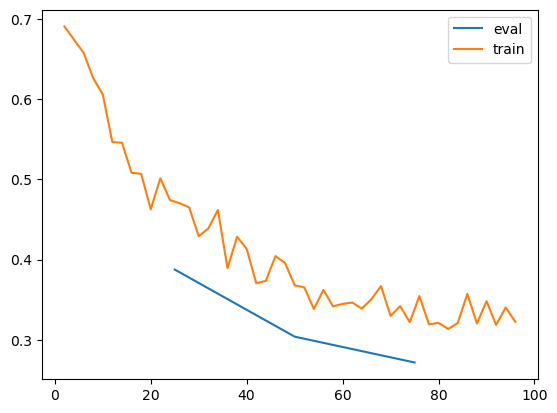

In [19]:
# Plot loss curves from trainer
import matplotlib.pyplot as plt

xs_train, loss_train = [], []
xs_eval, loss_eval = [], []
for x, log in enumerate(trainer.state.log_history):
    if "loss" in log:
        xs_train.append(log["step"])
        loss_train.append(log["loss"])
    if "eval_loss" in log:
        xs_eval.append(log["step"])
        loss_eval.append(log["eval_loss"])

plt.plot(xs_eval, loss_eval, label="eval")
plt.plot(xs_train, loss_train, label="train")
plt.legend()

## Evaluate

In [20]:
# model = Wav2Vec2ForSpeechClassification.from_pretrained(f"{trainer.args.output_dir}/checkpoint-final")

In [28]:
model = trainer.model

In [29]:
# Determine optimal cut-off probability for each phone
from sklearn.metrics import roc_curve

# Get predictions
trainer.model.eval()
with torch.no_grad():
    preds = trainer.predict(corpus["train"])
    labels = preds.label_ids
    preds = preds.predictions[0] if isinstance(preds.predictions, tuple) else preds.predictions

# Get optimal cut-off for each phone
optimal_thresholds = []
for j in range(preds.shape[-1]):
    preds_j = preds[:, j]
    labels_j = labels[:, j]

    mask = labels_j != -100
    preds_j = preds_j[mask]
    labels_j = labels_j[mask]

    fpr_j, tpr_j, thresholds_j = roc_curve(labels_j, preds_j, pos_label=1)
    optimal_thresholds.append(thresholds_j[np.argmax(tpr_j - fpr_j)])

optimal_thresholds = torch.tensor(optimal_thresholds)
optimal_thresholds

/userdata/jgauthier/transformers/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/userdata/jgauthier/transformers/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1132: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


tensor([    inf, -1.1913, -1.1925, -1.2072, -1.1712, -1.1808, -1.2802, -1.2811,
        -1.2755, -1.2698, -1.2679, -1.2775, -1.2808, -1.2827, -1.2817, -1.2746,
        -1.2756, -1.2110, -1.2038, -1.2092, -1.2087, -1.2176, -1.2151, -1.2183,
        -1.2150, -1.2783, -1.2741, -1.2699, -1.2668, -1.2778, -1.2852, -1.2739,
        -1.2786, -1.2820, -1.2758, -1.2708, -1.2786, -1.2738, -1.2712, -1.2760,
        -1.2750, -1.2783, -1.2688, -1.2745, -1.2760, -1.2765, -1.2784, -1.2763,
        -1.2706, -1.2769, -1.2768, -1.2726, -1.2743, -1.2744, -1.2777, -1.2788,
        -1.2776, -1.2754, -1.2710, -1.2727, -1.2828, -1.2755, -1.2813],
       device='cuda:0')

In [33]:
def predict(batch):
    features = processor(batch["input_values"], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)

    input_values = features.input_values.to(model.device)

    with torch.no_grad():
        logits = model(input_values).logits.cpu()
    preds = (logits > optimal_thresholds).int().numpy()

    # TODO trim based on label padding to match actual input length
    batch["score"] = logits.numpy()
    batch["distance_from_decision_threshold"] = logits - optimal_thresholds
    batch["predicted"] = preds
    return batch

eval_result = corpus["test"].select(range(30)).map(predict, batched=True, batch_size=8)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

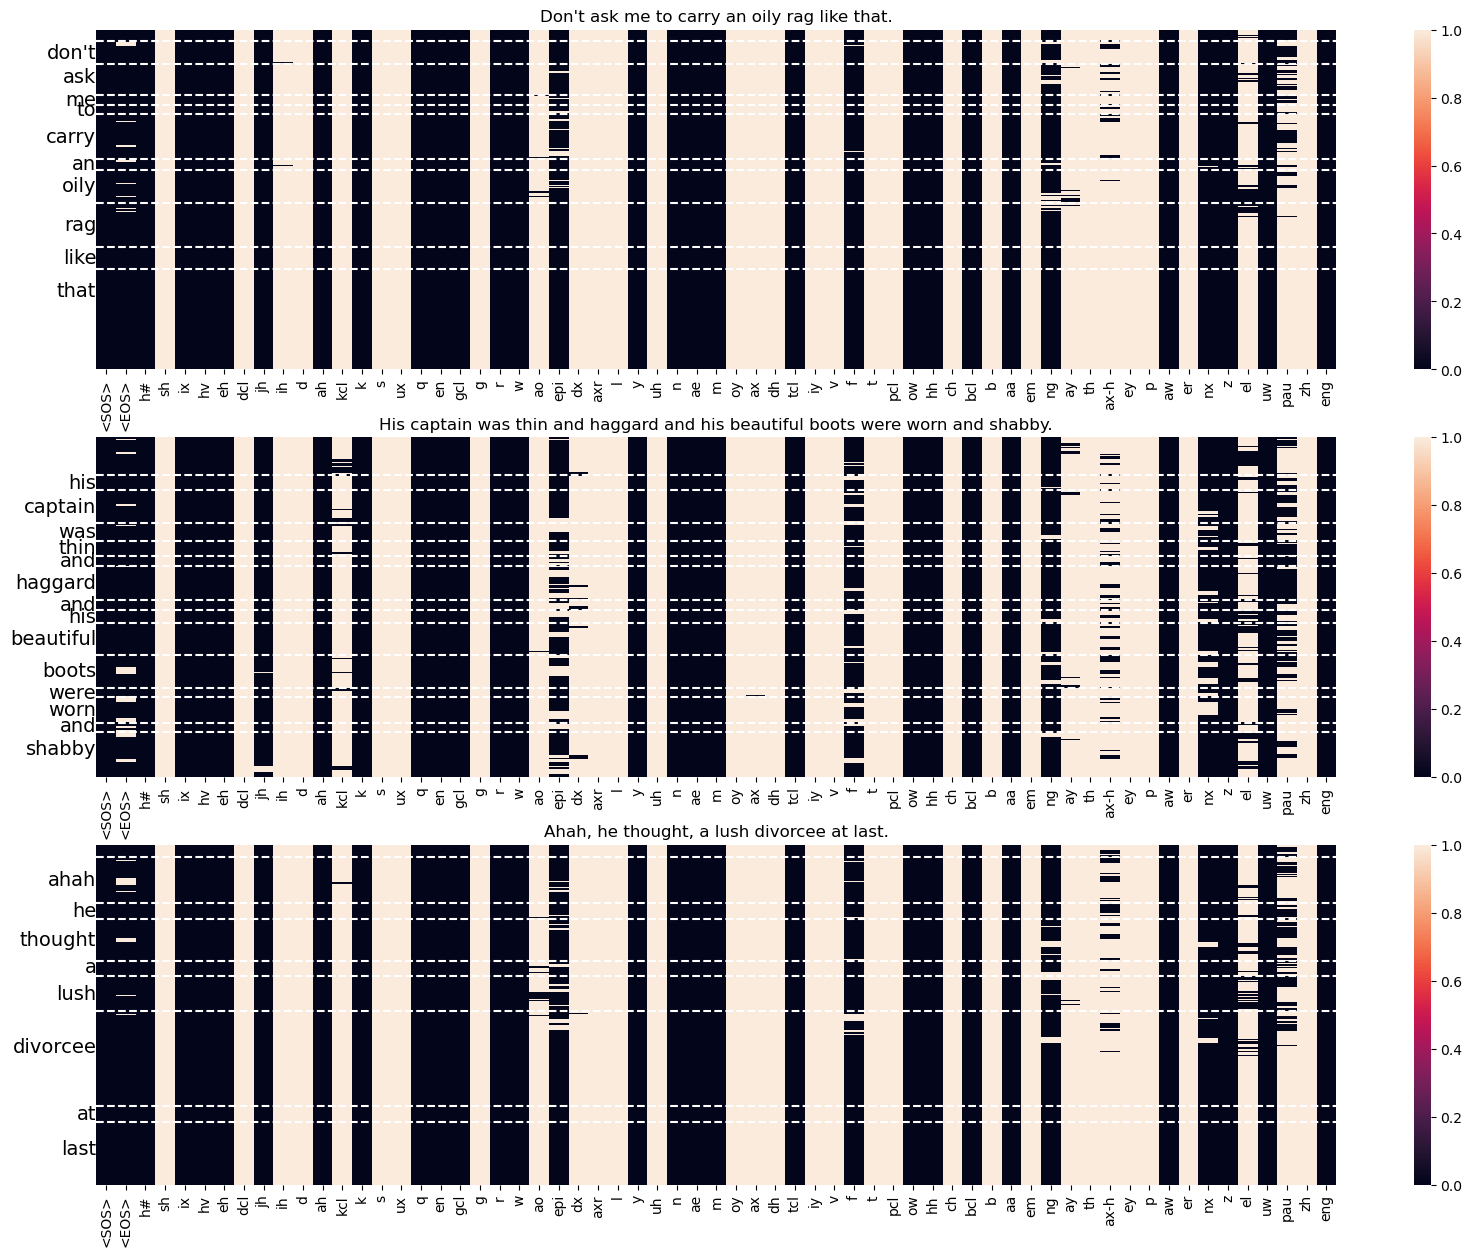

In [34]:
# viz phoneme predictions
n_to_plot = 3
f, axs = plt.subplots(n_to_plot, figsize=(20, 5 * n_to_plot))
plot_idxs = np.random.choice(len(eval_result), n_to_plot, replace=False).tolist()

for idx, ax in zip(plot_idxs, axs.ravel()):
    item = eval_result[idx]

    # compute compression ratio between input and output
    num_batch_frames = len(item["predicted"])#.shape[0]
    num_input_frames = len(item["input_values"])#.shape[0]
    compression_ratio = num_batch_frames / num_input_frames

    from matplotlib import pyplot as plt
    import seaborn as sns

    result = pd.DataFrame(item["predicted"], columns=phone_vocab.index2token)
    sns.heatmap(result, ax=ax)
    ax.set_title(item["text"])
    ax.set_yticks([])

    word_detail = item["word_detail"]
    for start, stop, word in zip(word_detail["start"], word_detail["stop"], word_detail["utterance"]):
        start = start * compression_ratio
        stop = stop * compression_ratio

        ax.axhline(start, color="white", linestyle="--")
        # show phone centered over its span
        ax.text(0, (start + stop) / 2, word, ha="right", va="center", fontsize=14)

    # f, ax = plt.subplots(figsize=(20, 5))

    # phonetic_detail = item["phonetic_detail"]
    # for start, stop, phone in zip(phonetic_detail["start"], phonetic_detail["stop"], phonetic_detail["utterance"]):
    #     ax.axvline(start, color="black", linestyle="--")
    #     # show phone centered over its span
    #     ax.text((start + stop) / 2, 0, phone, ha="center", va="center", fontsize=14)

In [223]:
# y_true = [all_dialects[i] for i in eval_result["labels"]]
# y_pred = [all_dialects[i] for i in eval_result["predicted"]]
y_true = eval_result["labels"]
y_pred = eval_result["predicted"]

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
print(classification_report(y_true, y_pred, target_names=all_dialects))

KeyError: "Column labels not in the dataset. Current columns in the dataset: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'score', 'distance_from_decision_threshold', 'predicted']"

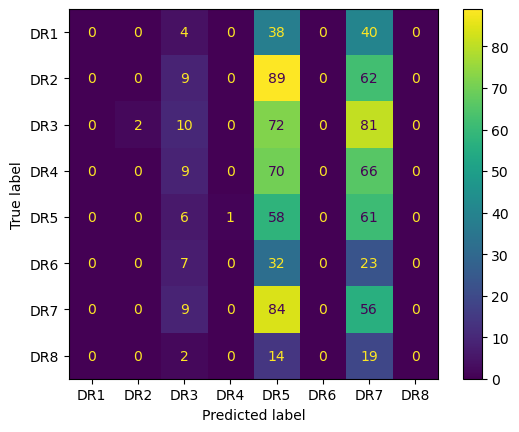

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=all_dialects).plot()